In [22]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import xgboost
import shap
import os
import sys
import torch

import seaborn as sns

from sklearn import metrics
from scipy import stats
from scipy.stats import entropy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn import metrics
from sklearn import preprocessing


from econml.dr import LinearDRLearner
from captum.attr import IntegratedGradients

module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models as cate_models
from catenets.models.jax import TNet, SNet,SNet1, SNet2, SNet3, DRNet, RANet, PWNet, RNet, XNet
from catenets.experiment_utils.simulation_utils import simulate_treatment_setup

In [36]:
def KL_divergence(a, b):
    epsilon = 1e-35 
    a += epsilon
    b += epsilon

    return np.mean(a * np.log(a/b))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def rmse(x1, x2):
    return np.sqrt(np.mean((x1 - x2)**2))


def simulation(var_size, n , low, high, random_state):
    
    np.random.seed(random_state)
    cov = np.random.uniform(low=-1, high=1, size=((var_size,var_size)))
    
    ### control 
    mu0 = np.zeros(var_size)
    x0 = np.random.multivariate_normal(mu0, 0.5*cov, size=int(n/2))

    ### treated
    mu1 = np.random.uniform(low=low, high=high, size=(var_size))
    x1 = np.random.multivariate_normal(mu1, 0.5*cov, size=int(n/2))
    
    X = np.concatenate((x0, x1))
    
    #### Treatment assignment
    w_t = np.random.uniform(low=-0.1, high=0.1, size=((var_size,1)))
    n_t = np.random.normal(0, 0.1)

    p = sigmoid(np.dot(X, w_t) + n_t)
    w = np.random.binomial(1, p=p)
    
    #### Potential outcome

    w_ty = np.random.uniform(low=-1, high=1, size=((var_size,2)))
    n_ty = np.random.multivariate_normal(np.zeros((2)), 0.1*np.eye(2))    
    y_po = np.dot(X, w_ty) + n_ty

    
    return X, y_po, w, p, KL_divergence(mu1,mu0)

In [4]:
n = 5000
feature_size = 20
random_state = 0
low = 0.
high = 0.0

X, y_po, w, p, KL = simulation(feature_size, n, low, high, random_state)

print(KL)

rng = np.random.default_rng(random_state)
inds = np.arange(n)
rng.shuffle(inds)

n_train = int(0.8 * n)

train_inds = inds[:n_train]
test_inds = inds[n_train:]

X_train, X_test = X[train_inds,:], X[test_inds,:]
w_train = w[train_inds,:]
y_train = np.take_along_axis(y_po,w, 1)[train_inds, :]
y_test_cate = y_po[test_inds, 1] - y_po[test_inds, 0]

0.0


covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


(array([   8.,   66.,  261.,  711., 1140., 1305.,  973.,  417.,  104.,
          15.]),
 array([0.31540916, 0.36085203, 0.4062949 , 0.45173777, 0.49718064,
        0.54262351, 0.58806638, 0.63350925, 0.67895212, 0.72439499,
        0.76983786]),
 <BarContainer object of 10 artists>)

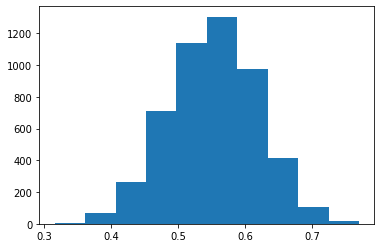

In [5]:
plt.hist(p)

[[0.54752069]
 [0.51086519]
 [0.62587674]
 ...
 [0.45701984]
 [0.63779613]
 [0.53496303]]


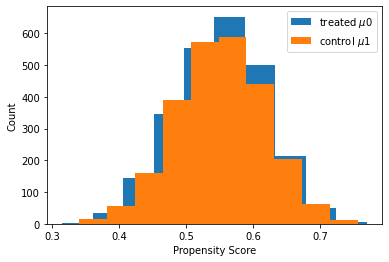

In [12]:
treated_p = p[:2500]
control_p =  p[2500:]

plt.hist(treated_p, label = "treated $\mu0$")
plt.hist(control_p, label = "control $\mu1$")

plt.ylabel("Count")
plt.xlabel("Propensity Score")
#plt.title('KL divergence %s' % KL(mu_1,mu_0))
plt.legend()

print(p)

In [27]:
### single learner as oracle
DR = DRNet()
DR.fit(X_train, y_train, w_train)

def DR_predict(X):
    return DR.predict(X)

Permutation explainer: 1001it [02:47,  5.82it/s]                                  


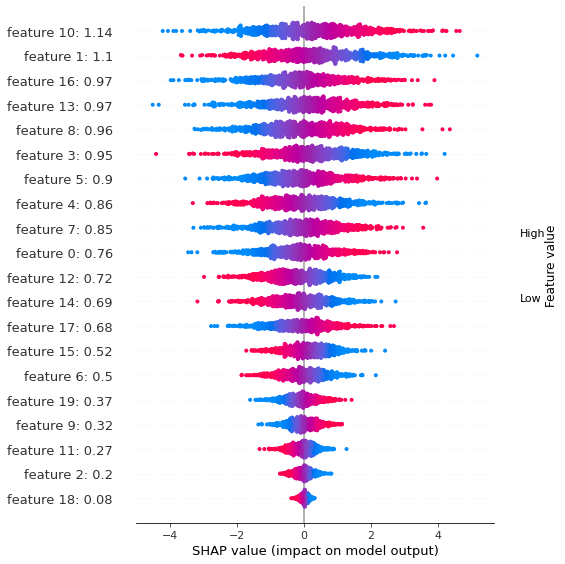

In [53]:
explainer = shap.Explainer(DR_predict, X_train)

#### showing explanation on cate
shap_values = explainer(X_test)

names = ["feature " + str(i) for i in range(feature_size)]
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

shap.summary_plot(shap_values, feature_names=feature_names)

dr_unbiased = (shap_values.values).mean(0)
dr_unbiased_abs = np.abs(shap_values.values).mean(0)

In [28]:
torch_DR = cate_models.torch.DRLearner(
                    X_train.shape[1],
                    binary_y=(len(np.unique(y_train)) == 2),
                    n_layers_out=2,
                    n_units_out=100,
                    n_iter=1000,
                    batch_size=1024,
                    batch_norm=False,
                    nonlin="relu",
                    )

In [29]:
torch_DR.fit(X=X_train, y=y_train, w=w_train)

DRLearner(
  (_te_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=20, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=1, bias=True)
    )
  )
  (_po_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=20, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=1, bias=True)
    )
  )
  (_propensity_estimator): PropensityNet(
    (model): Sequential(
      (0): Linear(in_features=20, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=2, bias=True)
      (3): Softmax(dim=-1)
    )
  )
)

False


In [44]:
test_input_tensor = torch.from_numpy(X_test).type(torch.FloatTensor).to("cuda:0")

pehe_dr = rmse(y_test_cate, DR_predict(X_test))
pehe_dr_torch = rmse(y_test_cate, torch_DR.predict(test_input_tensor).detach().cpu().numpy())

print(pehe_dr, pehe_dr_torch)

4.675553 4.690394454222892


In [45]:
ig = IntegratedGradients(torch_DR)

In [48]:
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor, n_steps= 500, return_convergence_delta=True)
attr = attr.detach().cpu().numpy()

Average Feature Importances
feature 0 :  0.809
feature 1 :  1.163
feature 2 :  0.235
feature 3 :  1.045
feature 4 :  0.899
feature 5 :  1.004
feature 6 :  0.523
feature 7 :  0.956
feature 8 :  1.044
feature 9 :  0.363
feature 10 :  1.245
feature 11 :  0.278
feature 12 :  0.737
feature 13 :  0.988
feature 14 :  0.657
feature 15 :  0.546
feature 16 :  1.033
feature 17 :  0.750
feature 18 :  0.103
feature 19 :  0.371


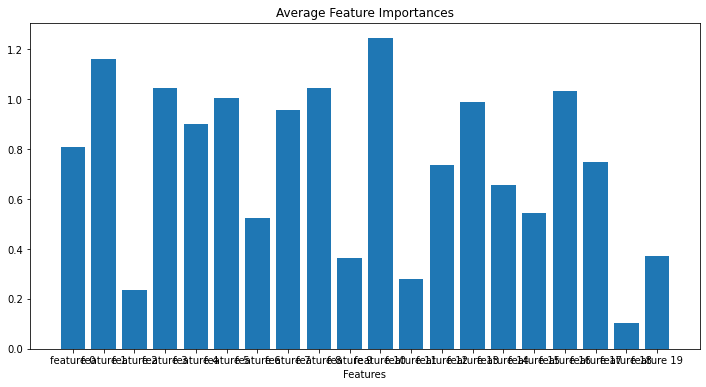

In [60]:
# Helper method to print importances and visualize distribution

def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

feature_names = ["feature " + str(i) for i in range(feature_size)]
visualize_importances(feature_names, np.mean(np.abs(attr), axis=0))

In [72]:
print(stats.spearmanr(dr_unbiased, np.mean(attr, axis=0)).correlation)

stats.spearmanr(dr_unbiased_abs, np.mean(np.abs(attr), axis=0)).correlation 

0.045112781954887216


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Permutation explainer: 1001it [00:54, 16.63it/s]                                  


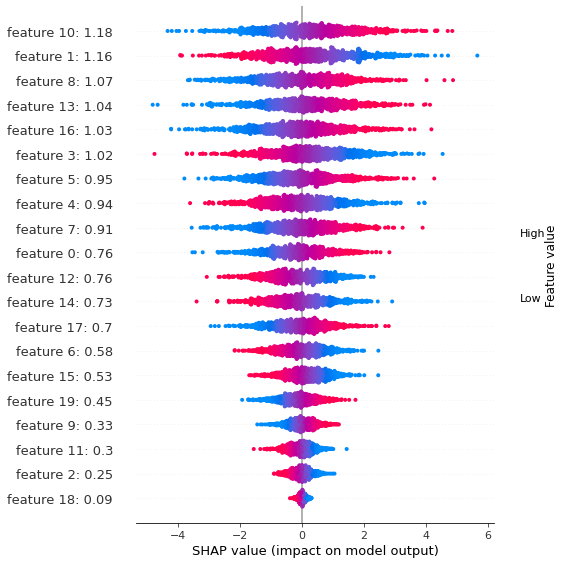

In [13]:
est = LinearDRLearner(model_propensity=GradientBoostingClassifier(),
                      model_regression=GradientBoostingRegressor())

est.fit(y_train, w_train, X=X_train)
treatment_effects = est.effect(X_test)

lb, ub = est.effect_interval(X_test, alpha=0.05)
#est.fit(y_train, w_train, X=X_train)
#shap_values_1 = est.shap_values(X_test)

def est_predict(X):
    return est.effect(X)

explainer = shap.Explainer(est_predict, X_train)

#### showing explanation on cate
shap_values = explainer(X_test)

names = ["feature " + str(i) for i in range(feature_size)]
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

shap.summary_plot(shap_values, feature_names=feature_names)

ecom_unbiased = (shap_values.values).mean(0)
ecom_unbiased_abs = np.abs(shap_values.values).mean(0)

In [16]:
stats.spearmanr(cate_unbiased, ecom_unbiased).correlation 

In [17]:
est_pred = est.effect(X_test)

pehe_1 = rmse(y_test_cate, est_pred)
pehe_2 = rmse(y_test_cate, s_predict(X_test))

print(pehe_1, pehe_2)

4.8433312298984035 4.675553


In [18]:
models = [TNet(), SNet() ,SNet1(), SNet2(), SNet3()
          ,DRNet(), RANet(), PWNet(), RNet(), XNet()]

In [ ]:
n = 5000
feature_size = 20
random_state = 0

mu_t = np.arange(0, 2.5, 0.2, dtype=float)
ecom_spearman_results = np.zeros((len(models), len(mu_t), 2))
cate_spearman_results = np.zeros((len(models), len(mu_t), 2))

pehes = np.zeros((len(models), len(mu_t)))
KL_results = np.zeros(len(mu_t))

### sample training index

rng = np.random.default_rng(random_state)
inds = np.arange(n)
rng.shuffle(inds)

n_train = int(0.8 * n)

train_inds = inds[:n_train]
test_inds = inds[n_train:]

for i, value in enumerate(mu_t):
    
    low = value
    high = value + 0.05
    X, y_po, w, p, KL = simulation(feature_size, n, low, high, random_state)
    
    print("KL is %s" %KL)
    
    KL_results[i] = KL
    
    X_train, X_test = X[train_inds,:], X[test_inds,:]
    w_train = w[train_inds,:]
    y_train = np.take_along_axis(y_po,w, 1)[train_inds, :]
    
    y_test_cate = y_po[test_inds, 1] - y_po[test_inds, 0]
    
    #### train CATEs
        
    for model_index, model in enumerate(models):
        cate_net = model
        
        def model_predict(X):
            return cate_net.predict(X)
        
        cate_net.fit(X_train, y_train, w_train)   
        
        #### predict potential outcomes
        
        pred_cate = cate_net.predict(X_test)
        pehe = rmse(y_test_cate, pred_cate)
        
        pehes[model_index, i] = pehe
        
        print("PHE %s for model %s"%(pehe,str(cate_net)))

        #### explaining CATE on testing sets.
        
        explainer = shap.Explainer(model_predict, X_train)
        shap_values = explainer(X_test)
        
        feature_imp = (shap_values.values).mean(0).round(2)
        feature_imp_abs = np.abs(shap_values.values).mean(0).round(2)
        
        ecom_spearman_results[model_index, i, 0] = stats.spearmanr(ecom_unbiased , feature_imp).correlation
        ecom_spearman_results[model_index, i, 1] = stats.spearmanr(ecom_unbiased_abs , feature_imp_abs).correlation
        cate_spearman_results[model_index, i, 0] = stats.spearmanr(cate_unbiased , feature_imp).correlation
        cate_spearman_results[model_index, i, 1] = stats.spearmanr(cate_unbiased_abs , feature_imp_abs).correlation

covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL is 2.205267758786774
PHE 4.6746683 for model TNet()


Permutation explainer: 1001it [03:48,  4.19it/s]                                  


PHE 4.66901 for model SNet()


Permutation explainer: 1001it [04:33,  3.52it/s]                                  


PHE 4.692527 for model SNet1()


Permutation explainer: 1001it [03:08,  4.99it/s]                                  


PHE 4.6729198 for model SNet2()


Permutation explainer: 1001it [02:43,  5.74it/s]                                  


PHE 4.6797175 for model SNet3()


Permutation explainer: 1001it [03:33,  4.48it/s]                                  


PHE 4.6786637 for model DRNet()


Permutation explainer: 1001it [02:05,  7.33it/s]                                  


PHE 4.679466 for model RANet()


Permutation explainer: 1001it [02:05,  7.35it/s]                                  


PHE 4.7172556 for model PWNet()


Permutation explainer: 1001it [02:04,  7.39it/s]                                  


PHE 4.6874447 for model RNet()


Permutation explainer: 1001it [02:13,  6.91it/s]                                  


PHE 4.676519 for model XNet()


Permutation explainer: 1001it [05:34,  2.90it/s]                                  
covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


KL is 18.085190775253423


In [ ]:
for i in range(len(models)):
    plt.plot(KL_results, ecom_spearman_results[i,:, 0], label=str(models[i]))

plt.legend()
plt.ylabel("Spearman's Rank - CATE")
plt.xlabel("KL divergence")
plt.show()

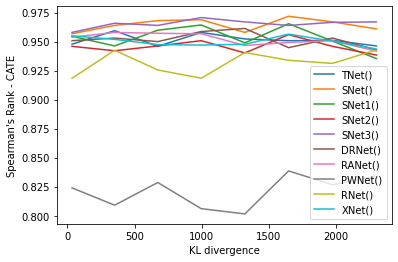

In [215]:
for i in range(len(models)):
    plt.plot(KL_results, ecom_spearman_results[i,:, 1], label=str(models[i]))

plt.legend()
plt.ylabel("Spearman's Rank - CATE")
plt.xlabel("KL divergence")
plt.show()

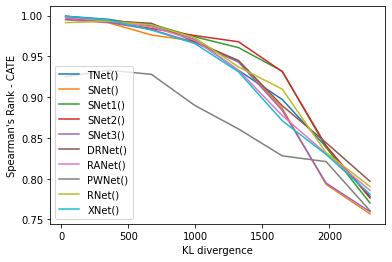

In [217]:
for i in range(len(models)):
    plt.plot(KL_results, cate_spearman_results[i,:, 0], label=str(models[i]))

plt.legend()
plt.ylabel("Spearman's Rank - CATE")
plt.xlabel("KL divergence")
plt.show()

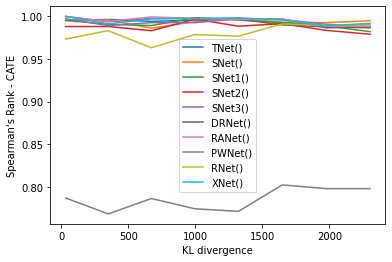

In [218]:
for i in range(len(models)):
    plt.plot(KL_results, cate_spearman_results[i,:, 1], label=str(models[i]))

plt.legend()
plt.ylabel("Spearman's Rank - CATE")
plt.xlabel("KL divergence")
plt.show()

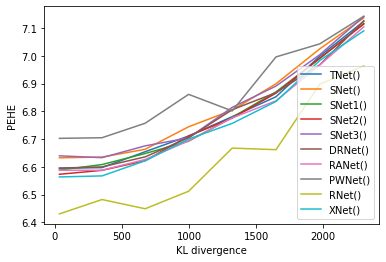

In [219]:
for i in range(len(models)):
    plt.plot(KL_results, pehes[i,:], label=str(models[i]))

plt.legend()
plt.xlabel("KL divergence")
plt.ylabel("PEHE")
plt.show()

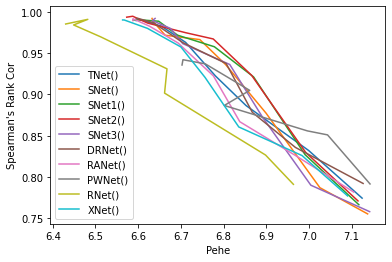

In [225]:
for i in range(len(models)):
    plt.plot(pehes[i,:], ecom_spearman_results[i,:, 0],label=str(models[i]))

plt.legend()
plt.xlabel("Pehe")
plt.ylabel("Spearman's Rank Cor")
plt.show()

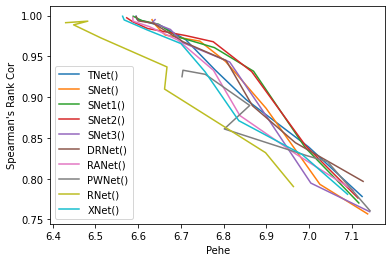

In [224]:
for i in range(len(models)):
    plt.plot(pehes[i,:], cate_spearman_results[i,:, 0],label=str(models[i]))

plt.legend()
plt.xlabel("Pehe")
plt.ylabel("Spearman's Rank Cor")
plt.show()

In [216]:
def t_2net_predict(X):
    return t_2.predict(X)

def tnet_predict(X):
    return t.predict(X)

def snet_predict(X):
    return s.predict(X)

Exact explainer: 1001it [06:02,  2.68it/s]                                        


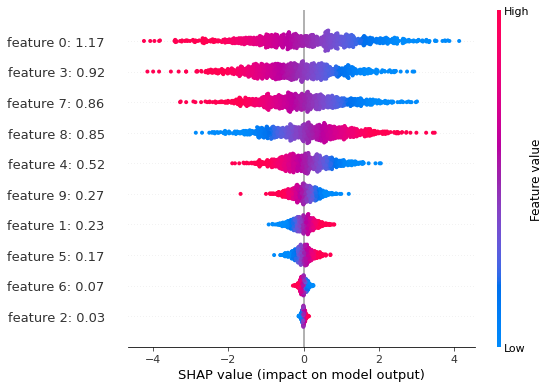

In [ ]:
explainer = shap.Explainer(t_2net_predict, X_train[:,:10])
shap_values = explainer(X_f_test[:, :10])

names = ["feature " + str(i) for i in range(10)]
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

shap.summary_plot(shap_values, feature_names=feature_names)

t_shap = (shap_values.values).mean(0)
t_shap_abs = np.abs(shap_values.values).mean(0)

Exact explainer: 1001it [06:02,  2.68it/s]                                        


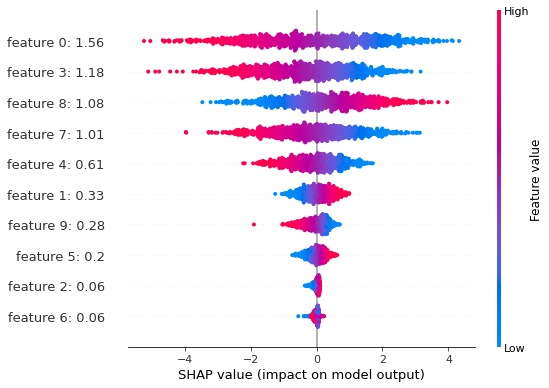

In [140]:
explainer = shap.Explainer(tnet_predict, X_train[:,:10])
shap_values = explainer(X_f_test[:, :10])

names = ["feature " + str(i) for i in range(10)]
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

shap.summary_plot(shap_values, feature_names=feature_names)

t_shap = (shap_values.values).mean(0)
t_shap_abs = np.abs(shap_values.values).mean(0)

Exact explainer: 1001it [06:51,  2.37it/s]                                        


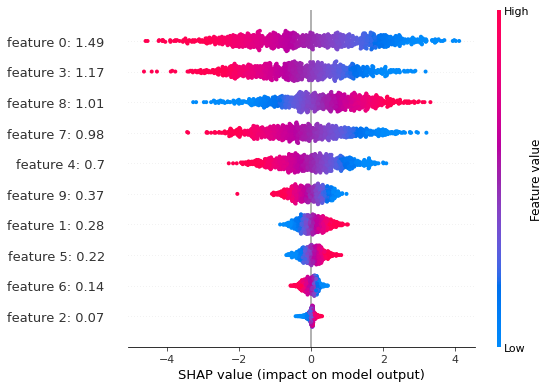

In [141]:
explainer = shap.Explainer(snet_predict, X_train[:,:10])
shap_values = explainer(X_f_test[:, :10])

names = ["feature " + str(i) for i in range(10)]
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

shap.summary_plot(shap_values, feature_names=feature_names)

s_shap = (shap_values.values).mean(0)
s_shap_abs = (np.abs(shap_values.values)).mean(0)

In [93]:
weights = w_ty[:,0] - w_ty[:,1]

stats.spearmanr(weights , unbiased_abs).correlation

0.09090909090909088

In [ ]:
# Load data
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
num_features = X.shape[1]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [ ]:
from shapreg import removal, games, shapley

# Make model callable
#model_lam = lambda x: model.predict(x)

# Model extension
marginal_extension = removal.MarginalExtension(X_f_test[:, :10], snet_predict)

In [ ]:
# Set up game (single prediction)
instance = X_train[1,:10]
game = games.PredictionGame(marginal_extension, instance)

explanation = shapley.ShapleyRegression(game, batch_size=32)

InvalidIndexError: (1, slice(None, 10, None))

In [ ]:
explanation

Shapley Values(
  (Mean): [[-1.90]
 [-0.43]
 [-0.03]
 [-0.72]
 [-0.36]
 [-0.20]
 [ 0.10]
 [-0.34]
 [-1.23]
 [-0.06]]
  (Std):  [[0.00]
 [0.00]
 [0.00]
 [0.00]
 [0.00]
 [0.00]
 [0.00]
 [0.00]
 [0.00]
 [0.00]]
)

['feature 0', 'feature 1', 'feature 2', 'feature 3', 'feature 4', 'feature 5', 'feature 6', 'feature 7', 'feature 8', 'feature 9']


TypeError: only size-1 arrays can be converted to Python scalars

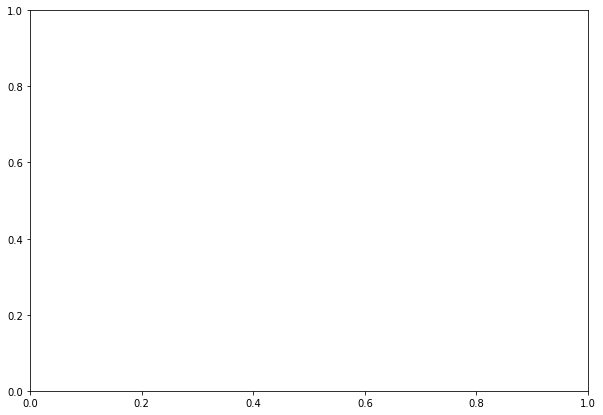

In [ ]:
# Plot with 95% confidence intervals
feature_names = [ "feature %s"% i for i in range(10)]

print(feature_names)

explanation.plot(feature_names, title='SHAP Values', sort_features=False)

In [13]:
w_t = np.random.uniform(low=-0.1, high=0.1, size=((25,1)))
n_t = np.random.normal(0, 0.1)

t_x = sigmoid(np.dot(x0, w_t) + n_t)

NameError: name 'x0' is not defined

In [15]:
# simulate some data (here: unconfounded, 10 prognostic variables and 5 predictive variables)

X, y, w, p, cate = simulate_treatment_setup(n=2000, d = 25, n_o=10, n_t=5, n_c=0)

In [25]:
p

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

invalid value encountered in log


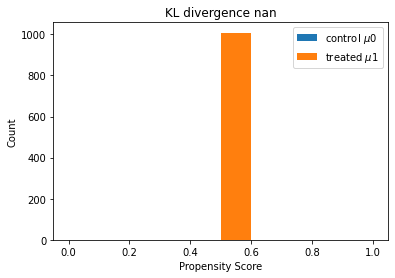

In [30]:
treated_idx = np.where(w==1)
control_idx = np.where(w==0)

treated_outcome = y[treated_idx]
treated_X = X[treated] 
treated_p = p[treated]
mu_1 = np.mean(treated_X,axis=0)

control_outcome = y[control_idx]
control_X = X[control_idx]
control_p = p[control_idx]
mu_0 = np.mean(control_X,axis=0)

plt.hist(treated_p, label = "control $\mu0$")
plt.hist(control_p, label = "treated $\mu1$")

plt.ylabel("Count")
plt.xlabel("Propensity Score")
plt.title('KL divergence %s' % KL(mu_1,mu_0))
plt.legend()

In [31]:
# estimate CATE using TNet
t = TNet()
t.fit(X, y, w)
cate_pred_t = t.predict(X)  # without potential outcomes
cate_pred_t, po0_pred_t, po1_pred_t = t.predict(X, return_po=True)  # predict potential outcomes too

# estimate CATE using SNet
s = SNet(penalty_orthogonal=0.01)
s.fit(X, y, w)
cate_pred_s = s.predict(X)

In [48]:
cate_pred_t.shape
X.shape

(2000, 25)

In [58]:
def f(X):
    return s.predict([X[:,i] for i in range(X.shape[1])]).flatten()

def f(X):
    return s.predict(X)

In [59]:
explainer = shap.Explainer(f, X)
shap_values = explainer(X)

names = ["feature " + str(i) for i in range(11)]
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

shap.summary_plot(shap_values, feature_names=feature_names)

unbiased = (shap_values.values).mean(0)
unbiased_abs = np.abs(shap_values.values).mean(0)

Permutation explainer:  18%|███▍               | 368/2000 [01:53<09:07,  2.98it/s]


KeyboardInterrupt: 